# This notebook will go through and compute the OMC astigmatism of the LHO and LLO interferometers by fitting lorentzians to each second order mode in an OMC scan

The astigmatism is given by the ratio of the lorentzian peak separation to the lorentzian peak width.

In [1]:
# notebook written on python 3.6.7

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import h5py

/Users/daniel_vander-hyde/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


# First we have to load the OMC data

In [2]:
hf = h5py.File('./data_LHO.h5')

scans_LHO = []

for key in hf.keys():
    scans_LHO.append(hf[key][:])
    
hf.close()
    
t = np.arange(len(scans_LHO[0]))/2.0**14

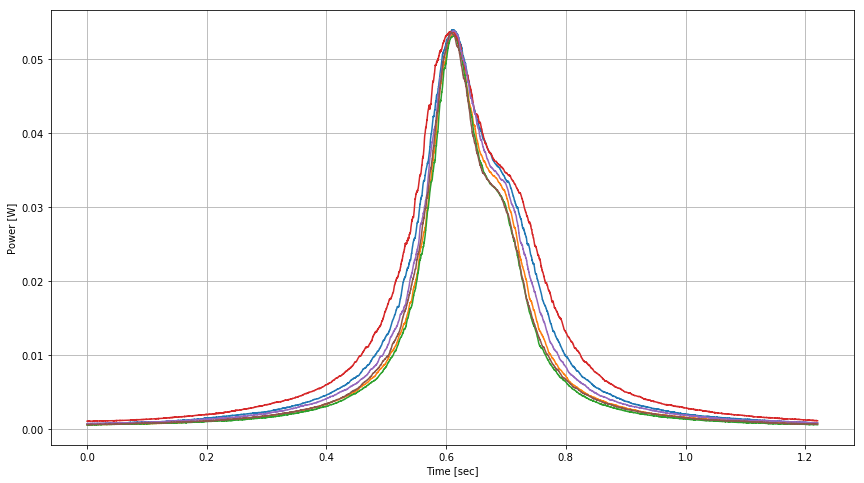

In [3]:
plt.figure(figsize=[8*1.8,8])
for scan in scans_LHO:
    plt.plot(t,scan)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.grid(True)

Note that even though every second order peak follows the same shape the width of the peak seems to change depending on which peak we are looking at. There are two possible explanations for this.

* The finesse of the OMC varies slowly (on the order of seconds) as a function of time.
* The rate at which the pzt changes length varies as across the scan.

I don't have any reason to believe that the finesse of the OMC would change on those sorts of timescales, much less for those changes to be visible in an OMC scan. The PZT on the other hand is known have noticeable hysterisis. This manifests itself as the PZT responding nonlinearly to voltage over large voltage ranges.

For the purposes of extracting the OMC astigmatism the inconsistent scan rate doesn't pose much of an issue if we make two key assumptions:

* The PZT nonlinearity is sufficiently small such that the scan rate is linear over the course of 1 second
* The finesse and the FSR of the OMC is constant.

This allows us to avoid fitting lopsided lorentzians that have been distorted due to nonlinear scan rate. We can also use the fitted lorentzian as a ruler to calibrate the scan rate over a small time interval.

# Optimization

Here we will have to employ non-linear least squares to fit the function

In [4]:
def lorentzian(x,fwhm=1,x0=0):
    '''maximum of lorentzian is 1.0'''
    return (fwhm/2)**2/((x-x0)**2+(fwhm/2)**2)

In [5]:
def objective_function(theta,x,y,mode='resid'):

    mid,sep,w,floor = theta[0:4]
    a_s = theta[4:] # this allows us to quickly vary the amount of lorentzians

    N_l = len(a_s) # number of lorentzians

    model = 0    
    for i,a in enumerate(a_s):
        # create cluster of lorentzians separated by sep with
        # center of cluseter at mid
        loc_i = mid + sep * (i - (N_l-1)/2)
        model += a*lorentzian(x,w,loc_i)    
    model = model + floor
    
    if mode == 'data':
        return y
    elif mode == 'model':
        return model
    elif mode == 'decomp':
        # return a list of individual lorentzians that
        # decompose the fit
        if len(theta) == 4:
            out = model
        else:
            out = []
            for i,a in enumerate(a_s):
                loc_i = mid + sep * (i - (N_l-1)/2)
                out.append(a*lorentzian(x,w,loc_i) + floor)
        return out 
    elif mode == 'resid':    
        return (y-model)

In [6]:
# we will go through the first peak by hand

scan = scans_LHO[0]

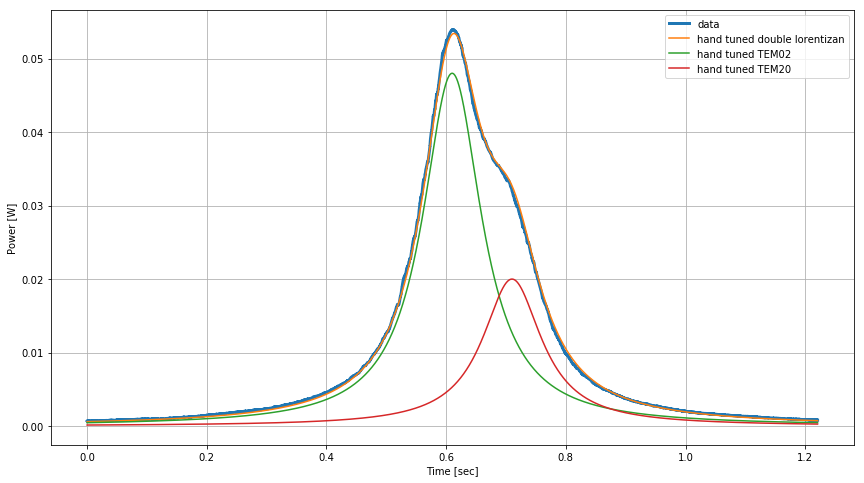

In [7]:
# do an initial guess

mid = 0.66
fwhm = 0.1
sep = 0.12
floor = 0
a0 = 4.8e-2
a1 = 2.0e-2

init = (mid,fwhm,sep,floor,a0,a1)


plt.figure(figsize=[8*1.8,8])
plt.plot(t,objective_function(init,t,scan,mode='data'),lw=3)
plt.plot(t,objective_function(init,t,scan,mode='model'))
for d in objective_function(init,t,scan,mode='decomp'):
    plt.plot(t,d)
plt.grid(True)

plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.legend(['data','hand tuned double lorentizan', 'hand tuned TEM02', 'hand tuned TEM20'])

Just briefly optimizing the parameters of a two lorentzian cluster we can get an already good fit by eye. Once we are happy we can pass the fit off to nonlinear least squares optimizer which will fiddle with the parameters to get a better fit.

In [8]:
# ftol,gtol,and xtol set the termination parameters of the fitting algorithm. 
# The fitting will terminate as soon as any of the three conditions are satisfied. Lowering their tolerances will 
# improve the quality of the fit.

# define bounds to stop the optimizer going into unphysical/unreasonable parameter spaces
bounds = np.array([[0,2],[0,1],[0,1],[0,1],[0,1],[0,1]])

# run the optimizer
soln = scipy.optimize.least_squares(objective_function,init,args=(t,scan),ftol=1e-12,gtol=1e-12,xtol=1e-12,bounds=bounds.T)

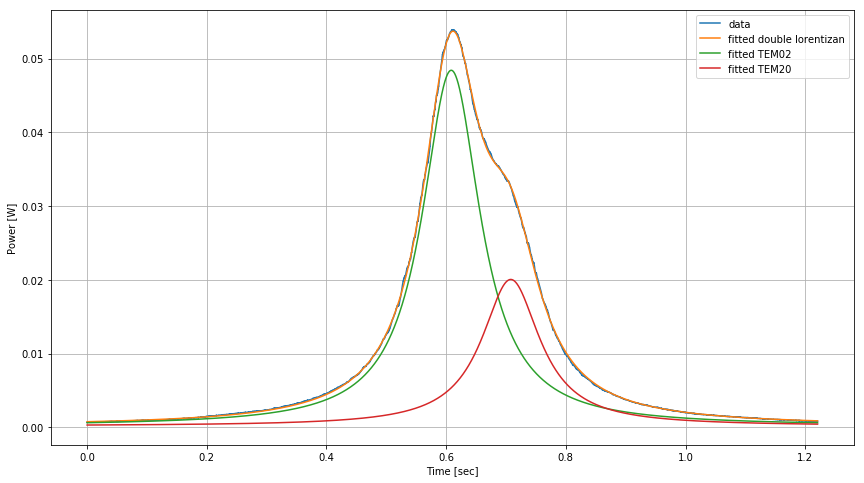

In [9]:
# plot the resulting fit and decomposition

plt.figure(figsize=[8*1.8,8])
model = objective_function(soln.x,t,scan,mode='model')

plt.plot(t,objective_function(soln.x,t,scan,mode='data'))
plt.plot(t,model)
for d in objective_function(soln.x,t,scan,mode='decomp'):
    plt.plot(t,d)
plt.grid(True)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.legend(['data','fitted double lorentizan', 'fitted TEM02', 'fitted TEM20'])

# Looks pretty good.

We can further assess the quality of the fit by looking at the residual as we would expect only gaussian noise to remain.

Text(0, 0.5, 'Residual Power [W]')

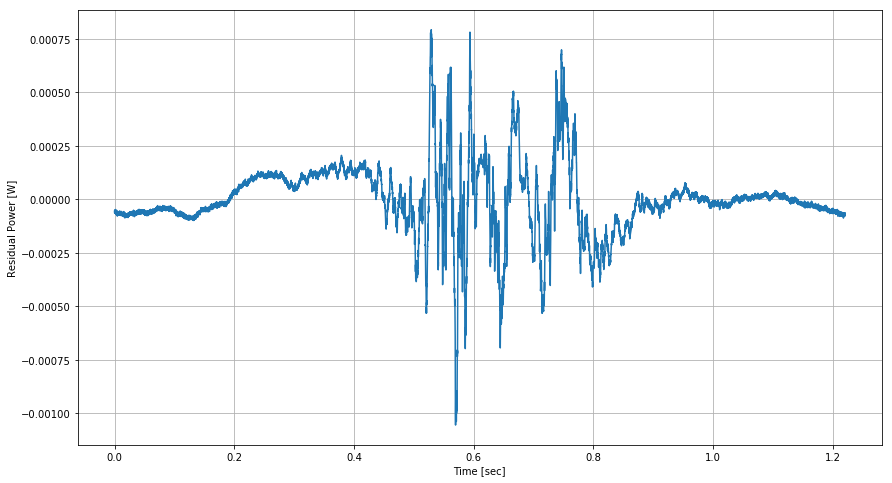

In [10]:
# plot the residual
plt.figure(figsize=[8*1.8,8])
resid = objective_function(soln.x,t,scan,mode='resid')
plt.plot(t,resid)
plt.grid(True)
plt.xlabel('Time [sec]')
plt.ylabel('Residual Power [W]')

# This is somewhat problematic.

The residual should be zero mean white gaussian noise for the least squares fit to be considered optimal. This residual isn't gaussian noise and it certainly isn't white.

It has been known that the LHO DCPD

However this shouldn't cause much of a problem for our calculation of OMC astigmatism. It introduce some bias in our parameter estimates however this bias isn't enough to change our conclusion about the OMC astigmatism.

# Calculating OMC astigmatism

In [11]:
fwhm = soln.x[1]
sep = soln.x[2]

# we divide by 2 since we only used the TEM02 and TEM20 modes and didn't include the TEM11
omc_astigmatism = fwhm/sep/2
display(omc_astigmatism)

0.42067056156631616

# Repeat for all the other second order peaks we saw in the OMC scan

In [12]:
solns = []

for scan in scans_LHO:
    soln = scipy.optimize.least_squares(objective_function,init,args=(t,scan),ftol=1e-12,gtol=1e-12,xtol=1e-12,bounds=bounds.T)
    solns.append(soln)
    
LHO_omc_astigmatisms = [x.x[1]/x.x[2]/2 for x in solns]

In [13]:
f'LHO_omc_astigmatism = {np.mean(LHO_omc_astigmatisms):4.3f} +/- {np.std(LHO_omc_astigmatisms):4.3f}'

'LHO_omc_astigmatism = 0.440 +/- 0.014'

# Repeat for LLO

In [14]:
hf = h5py.File('./data_LLO.h5')

scans_LLO = []

for key in hf.keys():
    scans_LLO.append(hf[key][:])
    
hf.close()

# keep only the first two peaks because the rest have much lower SNR
scans_LLO = scans_LLO[0:2]
    
t = np.arange(len(scans_LLO[0]))/2.0**14

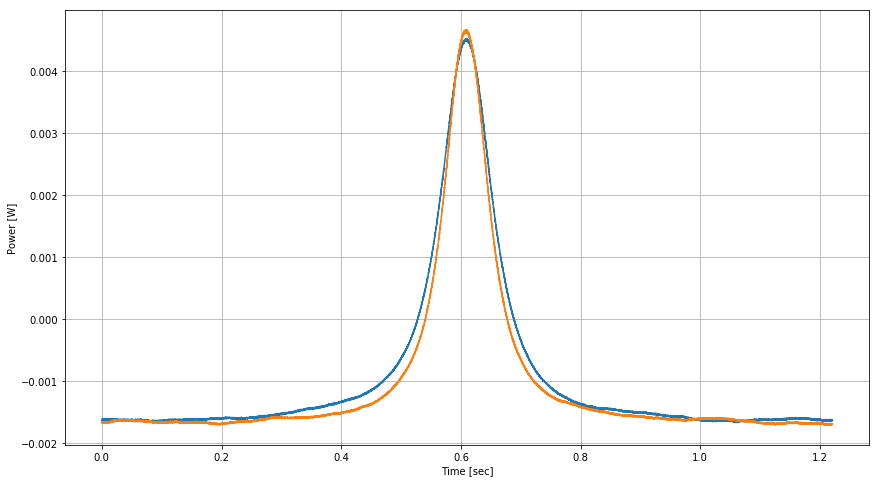

In [15]:
plt.figure(figsize=[8*1.8,8])
for scan in scans_LLO:
    plt.plot(t,scan)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.grid(True)

In [16]:
# do the first LLO scan by hand
scan = scans_LLO[0]

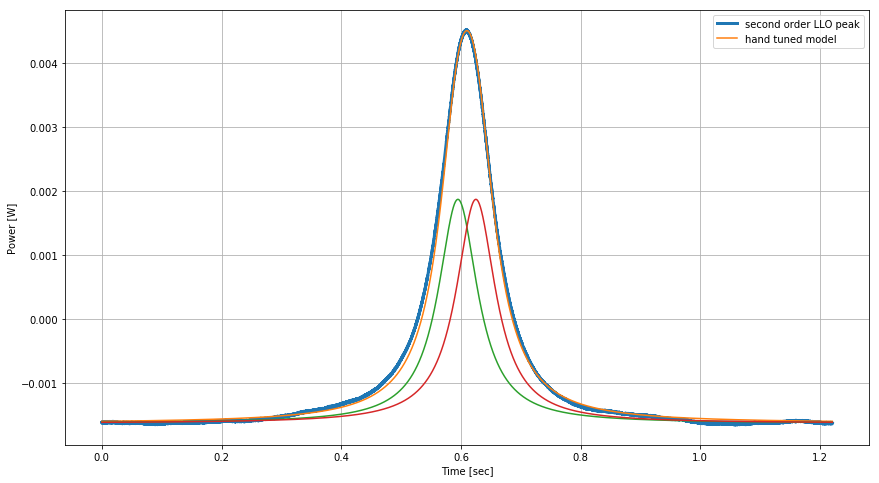

In [17]:
# do an initial guess

mid = 0.61
sep = 0.03
fwhm = 0.08
floor = np.percentile(scan,10)
a0 = 3.5e-3
a1 = 3.5e-3

# init = (0.84,0.1,0.12,0,4.8e-2,2.0e-2)
init = (mid,sep,fwhm,floor,a0,a1)

# init = (0.79,0.10,0,6e-1)
# init = (0.6,0.10,0,6e-1)

plt.figure(figsize=[8*1.8,8])
plt.plot(t,objective_function(init,t,scan,mode='data'),lw=3)
plt.plot(t,objective_function(init,t,scan,mode='model'))
for d in objective_function(init,t,scan,mode='decomp'):
    plt.plot(t,d)
plt.grid(True)

plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.legend(['second order LLO peak','hand tuned model'])

In [18]:
# ftol,gtol,and xtol set the termination parameters of the fitting algorithm. 
# The fitting will terminate as soon as any of the three conditions are satisfied. Lowering their tolerances will 
# improve the quality of the fit.

# define bounds to stop the optimizer going into unphysical/unreasonable parameter spaces
bounds = np.array([[0,2],[0,1],[0,1],[-1,1],[0,1],[0,1]])

# run the optimizer
soln = scipy.optimize.least_squares(objective_function,init,args=(t,scan),ftol=1e-12,gtol=1e-12,xtol=1e-12,bounds=bounds.T)

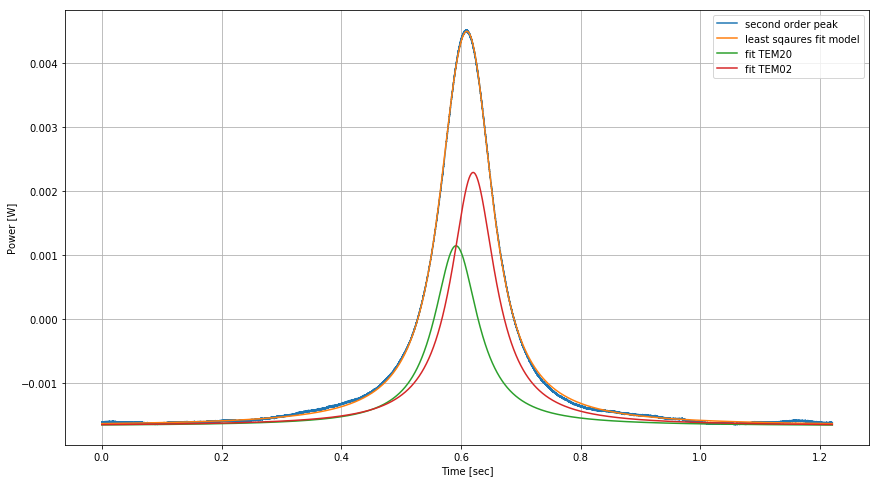

In [19]:
# plot the resulting fit and decomposition

plt.figure(figsize=[8*1.8,8])
model = objective_function(soln.x,t,scan,mode='model')

plt.plot(t,objective_function(soln.x,t,scan,mode='data'))
plt.plot(t,model)
for d in objective_function(soln.x,t,scan,mode='decomp'):
    plt.plot(t,d)
plt.grid(True)

plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.legend(['second order peak','least sqaures fit model','fit TEM20','fit TEM02'])

Fit looks reasonable. What does the residual say?

Text(0, 0.5, 'Residual Power [W]')

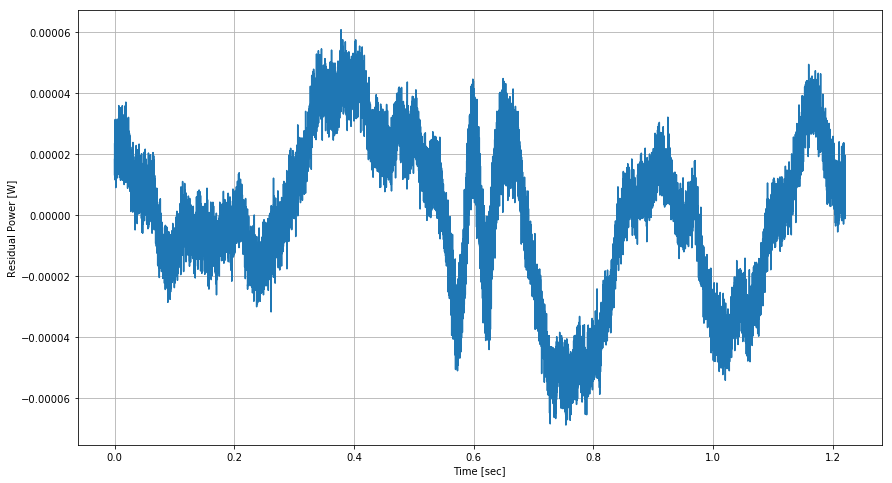

In [20]:
# plot the residual
plt.figure(figsize=[8*1.8,8])
resid = objective_function(soln.x,t,scan,mode='resid')
plt.plot(t,resid)
plt.grid(True)

plt.xlabel('Time [sec]')
plt.ylabel('Residual Power [W]')

This residual is different to the LHO one as LHO had an unaccounted noise that scaled with signal amplitude. LLO peaks seem to have constant noise amplitude but there is some feature remainining where the peak used to be. Looks like a different systematic is affecting the LLO fitting. My guess would be on the non white noise since when the fitting procedure is repeated after applying an apropriate whitening filter this feature goes away. The whitening isn't discussed here because it is beyond the scope of this notebook.

In [21]:
fwhm = soln.x[1]
sep = soln.x[2]

# we divide by 2 since we only used the TEM02 and TEM20 modes and didn't include the TEM11
LLO_omc_astigmatism = fwhm/sep/2
display(LLO_omc_astigmatism)

0.16074013518349206

# Repeat for the other peak

In [22]:
solns = []

for scan in scans_LLO:
    soln = scipy.optimize.least_squares(objective_function,init,args=(t,scan),ftol=1e-15,gtol=1e-12,xtol=1e-15,bounds=bounds.T)
    solns.append(soln)
    
LLO_omc_astigmatisms = [x.x[1]/x.x[2]/2 for x in solns]

In [23]:
f'LLO_omc_astigmatism = {np.mean(LLO_omc_astigmatisms):4.3f} +/- {np.std(LLO_omc_astigmatisms):4.3f}'

'LLO_omc_astigmatism = 0.167 +/- 0.006'

# Compare LHO and LLO together

In [24]:
display(f'LHO_omc_astigmatism = {np.mean(LHO_omc_astigmatisms):4.3f} +/- {np.std(LHO_omc_astigmatisms):4.3f}')
display(f'LLO_omc_astigmatism = {np.mean(LLO_omc_astigmatisms):4.3f} +/- {np.std(LLO_omc_astigmatisms):4.3f}')

'LHO_omc_astigmatism = 0.440 +/- 0.014'

'LLO_omc_astigmatism = 0.167 +/- 0.006'